Now that we've covered [regression](/posts/xgboost-for-regression-in-python/),
it's high time for a tutorial on solving classification problems in python with XGBoost.
Today we'll run through two examples: one for binary classification and another for multi-class classification.
We're going to use ready-to-train datasets from the scikit-learn datasets module for illustration, so check out the earlier post for [details on preparing data for use in XGBoost](/posts/xgboost-for-regression-in-python/).
After covering the training APIs from both scikit-learn and the native xgboost python library, we'll have a look at some performance metrics specific to both binary and multiclass classification.

Of course, you might also enjoy a deep dive on [the math behind XGBoost](/posts/xgboost-explained/)
or [the implementation details of multi-class gradient boosting](/posts/gradient-boosting-multi-class-classification-from-scratch/),
or you might want to check out the [full series on gradient boosting](/gradient-boosting-series/).

On to classification with XGBoost!



## Binary Classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import datasets

### Breast Cancer Dataset

[scikit-learn breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer)

[the paper](https://pubmed.ncbi.nlm.nih.gov/8168063/)

569 observations, they got 97% accuracy with 10-fold cross validation.

In [2]:
dbunch = datasets.load_breast_cancer(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
target = 'target' 
target_names = dbunch.target_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [3]:
for i, label in enumerate(target_names):
    print(f'{i}: {label}')

0: malignant
1: benign


<AxesSubplot:>

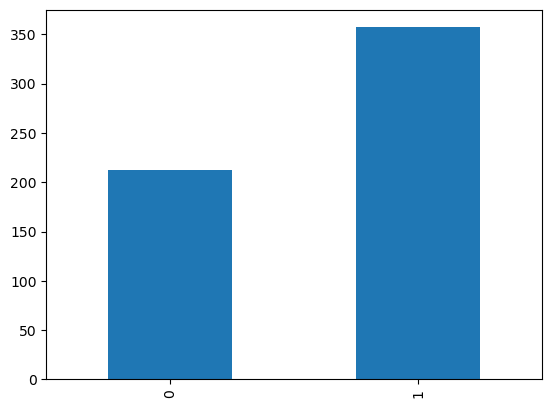

In [4]:
df.target.value_counts().sort_index().plot.bar()

In [5]:
n_valid = 50 

train_df, valid_df = df[:-n_valid], df[-n_valid:] 
train_df.shape, valid_df.shape

((519, 31), (50, 31))

[XGBoost parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [6]:
import xgboost as xgb 

# default values for important parameters
params = {
    'tree_method': 'exact',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'binary:logistic',
}
num_boost_round = 50

# scikit-learn interface
clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-logloss:0.46304	validation_1-logloss:0.47318
[10]	validation_0-logloss:0.04542	validation_1-logloss:0.08636
[20]	validation_0-logloss:0.01542	validation_1-logloss:0.05761
[30]	validation_0-logloss:0.00986	validation_1-logloss:0.04896
[40]	validation_0-logloss:0.00779	validation_1-logloss:0.04021
[49]	validation_0-logloss:0.00672	validation_1-logloss:0.03738


### Metrics 

[scikit-learn metrics for c]lassification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

In [7]:
from sklearn import metrics 

In [8]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])[:,1]

In [9]:
metrics.accuracy_score(y_true, y_pred)

1.0

In [10]:
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   malignant       1.00      1.00      1.00        10
      benign       1.00      1.00      1.00        40

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [11]:
metrics.roc_auc_score(y_true, y_score)

1.0

## Multi-Class Classification

### Forest Cover Type Dataset

[scikit-learn data documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype)

In [85]:
dbunch = datasets.fetch_covtype(as_frame=True)
df = dbunch.frame
features = dbunch.feature_names 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

<AxesSubplot:>

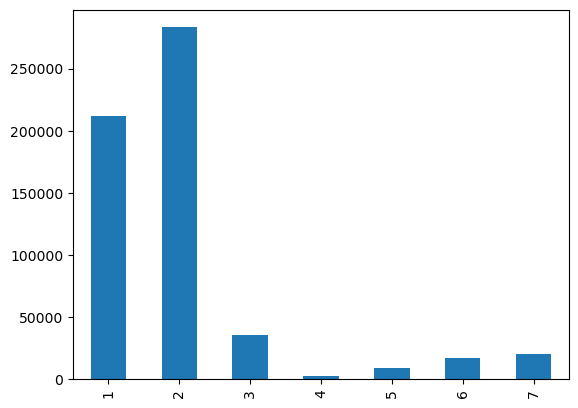

In [86]:
df['Cover_Type'].value_counts().sort_index().plot.bar()

In [87]:
from sklearn.preprocessing import LabelEncoder 

target = 'encoded'
enc = LabelEncoder()
df[target] = enc.fit_transform(df['Cover_Type'])

In [96]:
def train_test_split_random(df, n_valid):
    np.random.seed(42)
    idx_sort = np.random.permutation(len(df))
    idx_train, idx_test = idx_sort[:-n_valid], idx_sort[-n_valid:]
    return df.iloc[idx_train, :], df.iloc[idx_test, :]

train_df, valid_df = train_test_split_random(df, 20000)
train_df.shape, valid_df.shape

((561012, 56), (20000, 56))

In [110]:
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'multi:softprob',
    'num_class': df[target].nunique()
}
num_boost_round = 10

dtrain = xgb.DMatrix(label=train_df[target], data=train_df[features])
dvalid = xgb.DMatrix(label=valid_df[target], data=valid_df[features])
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10)

[0]	train-mlogloss:1.42072	valid-mlogloss:1.42131
[9]	train-mlogloss:0.60207	valid-mlogloss:0.60393


In [111]:
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'multi:softprob',
}
num_boost_round = 10

# scikit-learn interface
clf = xgb.XGBClassifier(n_estimators=num_boost_round, **params)
clf.fit(train_df[features], train_df[target], 
        eval_set=[(train_df[features], train_df[target]), (valid_df[features], valid_df[target])], 
        verbose=10);

[0]	validation_0-mlogloss:1.42072	validation_1-mlogloss:1.42131
[9]	validation_0-mlogloss:0.60207	validation_1-mlogloss:0.60393


In [112]:
y_true = valid_df[target]
y_pred = clf.predict(valid_df[features])
y_score = clf.predict_proba(valid_df[features])
y_true.shape, y_pred.shape, y_score.shape

((20000,), (20000,), (20000, 7))

In [113]:
metrics.accuracy_score(y_true, y_pred)

0.7763

In [114]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7316
           1       0.78      0.84      0.81      9730
           2       0.76      0.86      0.81      1246
           3       0.89      0.65      0.75        97
           4       0.88      0.25      0.38       310
           5       0.67      0.32      0.44       588
           6       0.89      0.67      0.77       713

    accuracy                           0.78     20000
   macro avg       0.81      0.62      0.67     20000
weighted avg       0.78      0.78      0.77     20000



In [115]:
metrics.roc_auc_score(y_true, y_score, average='weighted', multi_class='ovr')

0.9150519327739017

In [124]:
clf.score(valid_df[features], valid_df[target])

0.7763

In [127]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

scorer = make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)
permu_imp = permutation_importance(clf, valid_df[features], valid_df[target], 
                                   n_repeats=30, random_state=0, scoring=scorer)

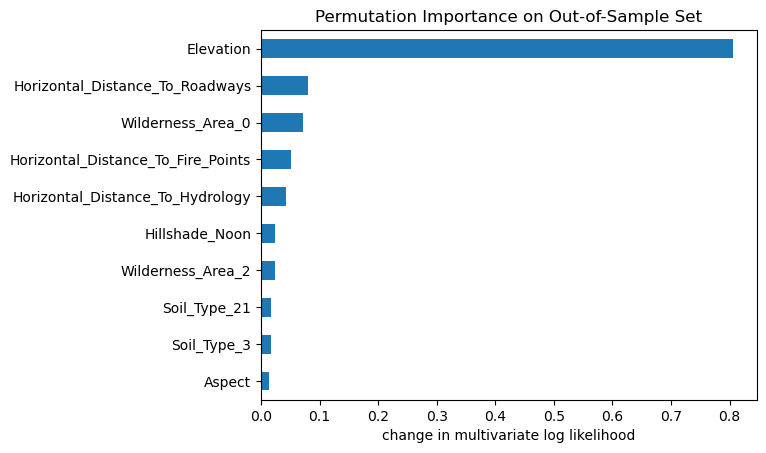

In [129]:
#| fig-alt: horizontal bar plot showing permutation feature importance
#| fig-cap: top 10 features by permutation importance on validation set

importances_permutation = pd.Series(permu_imp['importances_mean'], index=features)
importances_permutation.sort_values(ascending=True)[-10:].plot.barh()
plt.title('Permutation Importance on Out-of-Sample Set')
plt.xlabel('change in multivariate log likelihood');
